# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
import numpy as np
import pandas as pd
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify Project') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [4]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn('hour', get_hour(df.ts))

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)



In [6]:
## show important statistical values for each column
#columns = df.schema.names
#for column in columns:
#    df.describe(column).show()

In [7]:
## get a first overview
#for column in columns:
#    df.select(column).dropDuplicates().sort(column).show()

In [8]:
# drop relicts
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [9]:
# delete missing User IDs
df = df.filter(df['userId'] != '')

In [10]:
df = df.withColumn('userId_int', df['userId'].cast(IntegerType()))

In [11]:
# show data size after initial cleaning
df.count()

278154

In [12]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', userId_int=30)

In [13]:
## show clean data
#columns = df.schema.names
#for column in columns:
#    df.select(column).dropDuplicates().sort(column).show()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# get an overview over most artists
df.filter(df.page == 'NextSong') \
  .select('Artist') \
  .groupBy('Artist') \
  .agg({'Artist':'count'}) \
  .withColumnRenamed('count(Artist)', 'Artistcount') \
  .sort(desc('Artistcount')) \
  .show(10)

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
|      The Black Keys|       1125|
|                Muse|       1090|
|       Justin Bieber|       1044|
|        Jack Johnson|       1007|
|              Eminem|        953|
+--------------------+-----------+
only showing top 10 rows



In [15]:
# get an overview over most played songs
df.filter(df.page == 'NextSong') \
  .select('song', 'Artist') \
  .groupBy('song', 'Artist') \
  .agg({'song':'count'}) \
  .withColumnRenamed('count(song)', 'songcount') \
  .sort(desc('songcount')) \
  .show(10)

+--------------------+--------------------+---------+
|                song|              Artist|songcount|
+--------------------+--------------------+---------+
|      You're The One|       Dwight Yoakam|     1122|
|                Undo|            BjÃÂ¶rk|     1026|
|             Revelry|       Kings Of Leon|      854|
|       Sehr kosmisch|            Harmonia|      728|
|Horn Concerto No....|Barry Tuckwell/Ac...|      641|
|Dog Days Are Over...|Florence + The Ma...|      574|
|             Secrets|         OneRepublic|      463|
|        Use Somebody|       Kings Of Leon|      459|
|              Canada|    Five Iron Frenzy|      434|
|             Invalid|            Tub Ring|      424|
+--------------------+--------------------+---------+
only showing top 10 rows



In [16]:
# show the pages a user can go to to identify possible churn-state-transitions
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [17]:
# create the churn column
churn_users = df.filter(df.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
churn_users_list = [user['userId'] for user in churn_users.collect()]
df = df.withColumn('churn', df.userId.isin(churn_users_list))

In [18]:
# count unique UserIDs who have filed a cancellation at least once
df.filter(df.churn == True).select('userId').dropDuplicates().count()

52

In [19]:
# identify the stage transition paid->free and call mark it as a 1 for all users before the downgrading process in 'phase'
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df = df.withColumn('downgraded', flag_downgrade_event('page'))

windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn('phase', Fsum('downgraded').over(windowval))

df = df.withColumn('phase_bool', df.phase >= 1)
df = df.withColumn('phase_bool', df['phase_bool'].cast(IntegerType()))

In [20]:
# test the paid->free stage transition 'downgraded' for user 131
df.select(['userId_int', 'ts', 'page', 'level', 'churn', 'downgraded', 'phase' , 'phase_bool']).where(df.userId_int == 131).sort('ts').show(5000)

+----------+-------------+----------------+-----+-----+----------+-----+----------+
|userId_int|           ts|            page|level|churn|downgraded|phase|phase_bool|
+----------+-------------+----------------+-----+-----+----------+-----+----------+
|       131|1538384355000|        NextSong| free|false|         0|    2|         1|
|       131|1538384770000|        NextSong| free|false|         0|    2|         1|
|       131|1538385046000|        NextSong| free|false|         0|    2|         1|
|       131|1538385180000|        NextSong| free|false|         0|    2|         1|
|       131|1538385402000|        NextSong| free|false|         0|    2|         1|
|       131|1538385558000|        NextSong| free|false|         0|    2|         1|
|       131|1538386074000|        NextSong| free|false|         0|    2|         1|
|       131|1538386309000|        NextSong| free|false|         0|    2|         1|
|       131|1538386520000|        NextSong| free|false|         0|    2|    

In [21]:
## what is the action step ratio of paid/free subscription for individual users who downgraded at least once
#grouping = df.groupby(['userId_int']).agg({'phase_bool':'mean'}).withColumnRenamed('avg(phase_bool)', 'PaidFreeRatio')
#grouping.filter(grouping.PaidFreeRatio > 0).sort('PaidFreeRatio').show(500)

In [22]:
df = df.withColumn('level_bool', (df.level == 'paid').cast(IntegerType()))
#df.groupBy(['userId_int']).agg({'level_bool':'mean'}).show(500)

In [23]:
from pyspark.sql.functions import sum, countDistinct, avg, ceil, count
w = Window.partitionBy('userId_int')
# was the user ever in a paid subscription
df = df.withColumn('EverPaid', avg('level_bool').over(w))
df = df.withColumn('EverPaid', ceil('EverPaid'))

# what is the action step ratio of paid/free subscription for individual users who downgraded at least once (roughly estimated)
df = df.withColumn('PaidFreeRatio', avg('phase_bool').over(w))
# if the user never subscriped to full plan PaidFreeRatio is 0
# if the user subscriped to full plan but never cancelled the PaidFreeRatio is 1
# else PaidFreeRatio as described before!
PFR = udf(lambda x, y: (x * y) if (x > 0 and y > 0) else ((1) if (x > 0 and y == 0) else (0)))
df = df.withColumn('PaidFreeRatio', PFR(df.EverPaid, df.PaidFreeRatio))

df = df.drop('EverPaid')
df = df.drop('downgraded')

# test
df.select(['userId_int', 'page', 'level', 'churn', 'phase' , 'phase_bool', 'PaidFreeRatio']).show(5000)

+----------+----------------+-----+-----+-----+----------+-------------------+
|userId_int|            page|level|churn|phase|phase_bool|      PaidFreeRatio|
+----------+----------------+-----+-----+-----+----------+-------------------+
|       148|          Logout| free|false|    0|         0|                  0|
|       148|        NextSong| free|false|    0|         0|                  0|
|       148|        NextSong| free|false|    0|         0|                  0|
|       148|        NextSong| free|false|    0|         0|                  0|
|       148|        NextSong| free|false|    0|         0|                  0|
|       148|            Home| free|false|    0|         0|                  0|
|       148|        NextSong| free|false|    0|         0|                  0|
|       148|            Home| free|false|    0|         0|                  0|
|       148|          Logout| free|false|    0|         0|                  0|
|       148|        NextSong| free|false|    0|     

In [24]:
# analyze gender dependence on churn
df.dropDuplicates(['userId_int']).groupby(['gender','churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   32|
|     F|false|   84|
|     F| true|   20|
|     M|false|   89|
+------+-----+-----+



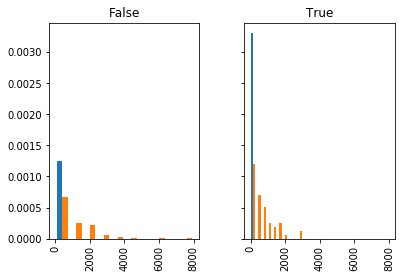

In [85]:
# analyze dependency of amount of played songs on churn
df.where(df.song != 'null').groupby(['churn','userId']).agg(count(df.song).alias('PlayedSongs')).orderBy('churn').toPandas().hist(['PlayedSongs'], by = 'churn', sharex = True, sharey = True, bins = 10, density = True);

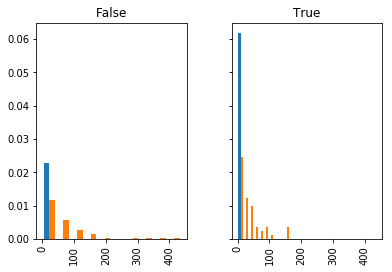

In [26]:
# analyze dependency of amount of 'Thumbs Up' on churn
df.where(df.page == 'Thumbs Up').groupby(['churn','userId']).agg(count(df.page).alias('ThumbsUpCounter')).orderBy('churn').toPandas().hist(['ThumbsUpCounter'], by = 'churn', sharex = True, sharey = True, bins = 10, density = True);

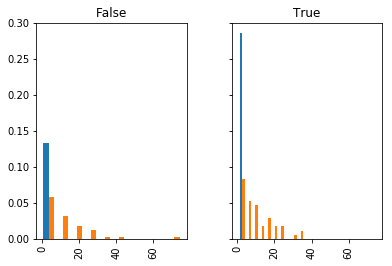

In [27]:
# analyze dependency of amount of 'Thumbs Down' on churn
df.where(df.page == 'Thumbs Down').groupby(['churn','userId']).agg(count(df.page).alias('ThumbsDownCounter')).orderBy('churn').toPandas().hist(['ThumbsDownCounter'], by = 'churn', sharex = True, sharey = True, bins = 10, density = True);

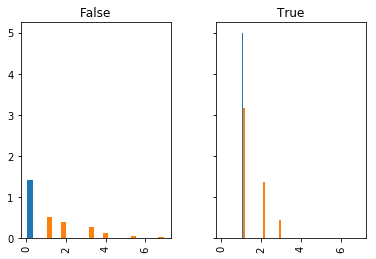

In [28]:
# analyze dependency of amount of 'Error' on churn
df.where(df.page == 'Error').groupby(['churn','userId']).agg(count(df.page).alias('ErrorCounter')).orderBy('churn').toPandas().hist(['ErrorCounter'], by = 'churn', sharex = True, sharey = True, bins = 10, density = True);

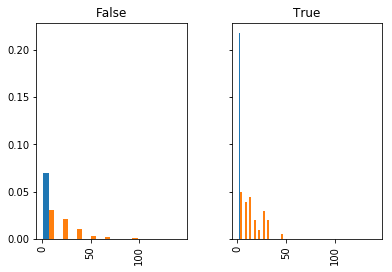

In [29]:
# analyze dependency of amount of added friends on churn
df.where(df.page == 'Add Friend').groupby(['churn','userId']).agg(count(df.page).alias('AddFriendCounter')).orderBy('churn').toPandas().hist(['AddFriendCounter'], by = 'churn', sharex = True, sharey = True, bins = 10, density = True);

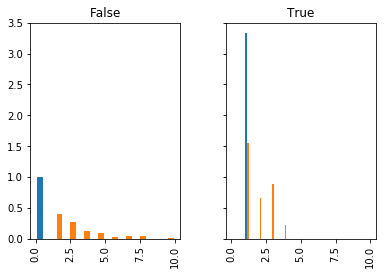

In [30]:
# analyze dependency of amount of setting changes on churn
df.where(df.page == 'Save Settings').groupby(['churn','userId']).agg(count(df.page).alias('SaveSettingsCounter')).orderBy('churn').toPandas().hist(['SaveSettingsCounter'], by = 'churn', sharex = True, sharey = True, bins = 10, density = True);

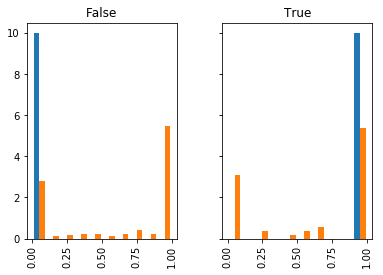

In [31]:
# analyze dependency of PaidFreeRatio on churn
df.groupby(['churn','userId']).agg({'PaidFreeRatio':'mean'}).orderBy('churn').toPandas().hist(['avg(PaidFreeRatio)'], by = 'churn', sharex = True, sharey = True, bins = 10, density = True);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [32]:
# create a label/feature data frame based on uder IDs
df_coll = []
# add churn as label and add gender/user activity as a feature
df_coll.append(df.replace(['F','M'], ['1', '0'], 'gender').groupby(['userId_int', 'churn', 'gender']).agg({'gender':'count'}).withColumnRenamed('count(gender)', 'userActivity').orderBy('userId_int'))
df_coll[-1] = df_coll[-1].withColumn("gender", df_coll[-1].gender.cast(IntegerType()))
df_coll[-1] = df_coll[-1].withColumn("churn", df_coll[-1].churn.cast(IntegerType()))
df_coll[-1].show()

+----------+-----+------+------------+
|userId_int|churn|gender|userActivity|
+----------+-----+------+------------+
|         2|    0|     1|         899|
|         3|    1|     0|         254|
|         4|    0|     0|        2442|
|         5|    0|     0|         218|
|         6|    0|     0|        3761|
|         7|    0|     0|         201|
|         8|    0|     1|         334|
|         9|    0|     0|        3191|
|        10|    0|     0|         795|
|        11|    0|     1|         848|
|        12|    1|     1|        1064|
|        13|    0|     1|        1654|
|        14|    0|     0|        1432|
|        15|    0|     0|        2278|
|        16|    0|     1|         819|
|        17|    1|     1|        1102|
|        18|    1|     0|         513|
|        19|    0|     1|         259|
|        20|    0|     1|        2195|
|        21|    0|     0|         589|
+----------+-----+------+------------+
only showing top 20 rows



In [33]:
# add SongsPlayed as a feature
df_coll.append(df.where(df.song != 'null').groupby(['userId_int']).agg({'song':'count'}).withColumnRenamed('count(song)', 'SongsPlayed').orderBy('userId_int'))
df_coll[-1].show()

+----------+-----------+
|userId_int|SongsPlayed|
+----------+-----------+
|         2|        755|
|         3|        214|
|         4|       2048|
|         5|        161|
|         6|       3159|
|         7|        150|
|         8|        251|
|         9|       2676|
|        10|        673|
|        11|        647|
|        12|        867|
|        13|       1280|
|        14|       1230|
|        15|       1914|
|        16|        675|
|        17|        927|
|        18|        429|
|        19|        216|
|        20|       1807|
|        21|        499|
+----------+-----------+
only showing top 20 rows



In [34]:
# add NoOfThumbsUp as a feature
df_coll.append(df.where(df.page == 'Thumbs Up').groupby(['userId_int']).agg({'page':'count'}).withColumnRenamed('count(page)', 'NoOfThumbsUp').orderBy('userId_int'))
df_coll[-1].show()

+----------+------------+
|userId_int|NoOfThumbsUp|
+----------+------------+
|         2|          29|
|         3|          14|
|         4|          95|
|         5|          11|
|         6|         165|
|         7|           7|
|         8|          16|
|         9|         118|
|        10|          37|
|        11|          40|
|        12|          42|
|        13|          57|
|        14|          54|
|        15|          81|
|        16|          42|
|        17|          40|
|        18|          20|
|        19|           5|
|        20|         106|
|        21|          27|
+----------+------------+
only showing top 20 rows



In [35]:
# add NoOfThumbsDown as a feature
df_coll.append(df.where(df.page == 'Thumbs Down').groupby(['userId_int']).agg({'page':'count'}).withColumnRenamed('count(page)', 'NoOfThumbsDown').orderBy('userId_int'))
df_coll[-1].show()

+----------+--------------+
|userId_int|NoOfThumbsDown|
+----------+--------------+
|         2|             6|
|         3|             3|
|         4|            26|
|         6|            31|
|         7|             1|
|         8|             3|
|         9|            32|
|        10|             4|
|        11|             9|
|        12|             9|
|        13|            14|
|        14|            12|
|        15|            14|
|        16|             4|
|        17|            13|
|        18|             1|
|        19|             2|
|        20|            21|
|        21|             2|
|        23|             6|
+----------+--------------+
only showing top 20 rows



In [36]:
# add NoOfErrors as a feature
df_coll.append(df.where(df.page == 'Error').groupby(['userId_int']).agg({'page':'count'}).withColumnRenamed('count(page)', 'NoOfErrors').orderBy('userId_int'))
df_coll[-1].show()

+----------+----------+
|userId_int|NoOfErrors|
+----------+----------+
|         4|         4|
|         6|         4|
|         7|         1|
|         8|         2|
|         9|         3|
|        11|         1|
|        12|         2|
|        14|         2|
|        15|         2|
|        20|         3|
|        21|         1|
|        28|         1|
|        30|         1|
|        33|         1|
|        35|         3|
|        36|         1|
|        37|         3|
|        38|         3|
|        39|         7|
|        41|         1|
+----------+----------+
only showing top 20 rows



In [37]:
# add NoOfAddedFriends as a feature
df_coll.append(df.where(df.page == 'Add Friend').groupby(['userId_int']).agg({'page':'count'}).withColumnRenamed('count(page)', 'NoOfAddedFriends').orderBy('userId_int'))
df_coll[-1].show()

+----------+----------------+
|userId_int|NoOfAddedFriends|
+----------+----------------+
|         2|              20|
|         3|               1|
|         4|              46|
|         5|               3|
|         6|              41|
|         7|               1|
|         8|               5|
|         9|              40|
|        10|              12|
|        11|               6|
|        12|              13|
|        13|              32|
|        14|              19|
|        15|              31|
|        16|              10|
|        17|              12|
|        18|              10|
|        19|               4|
|        20|              25|
|        21|               8|
+----------+----------------+
only showing top 20 rows



In [38]:
# add NoOfSettingChanges as a feature
df_coll.append(df.where(df.page == 'Save Settings').groupby(['userId_int']).agg({'page':'count'}).withColumnRenamed('count(page)', 'NoOfSettingChanges').orderBy('userId_int'))
df_coll[-1].show()

+----------+------------------+
|userId_int|NoOfSettingChanges|
+----------+------------------+
|         2|                 4|
|         4|                 2|
|         5|                 1|
|         6|                 2|
|         7|                 1|
|         9|                 1|
|        10|                 1|
|        11|                 2|
|        12|                 1|
|        13|                 4|
|        15|                 2|
|        18|                 1|
|        20|                 4|
|        21|                 1|
|        24|                 2|
|        25|                 2|
|        27|                 1|
|        29|                 4|
|        30|                 1|
|        33|                 2|
+----------+------------------+
only showing top 20 rows



In [39]:
df = df.withColumn('ts2', df.ts)
grouping = df.groupBy(['userId_int']).agg({'ts':'min', 'ts2':'max'}).withColumnRenamed('max(ts2)', 'T_max').withColumnRenamed('min(ts)', 'T_min').orderBy('userId_int')
grouping = grouping.withColumn('deltaT', ((grouping.T_max - grouping.T_min) / 10000000))
grouping = grouping.drop('T_max')
grouping = grouping.drop('T_min')
df = df.drop('ts2')
df_coll.append(grouping)
df_coll[-1].show()

+----------+--------+
|userId_int|  deltaT|
+----------+--------+
|         2|386.5209|
|         3|234.3009|
|         4|523.8898|
|         5|305.5732|
|         6|512.5003|
|         7|438.7742|
|         8|439.9439|
|         9|523.5372|
|        10|366.6568|
|        11|460.0073|
|        12|165.9487|
|        13| 514.062|
|        14|429.5597|
|        15|473.2403|
|        16|493.0225|
|        17| 92.2165|
|        18| 44.4073|
|        19|  5.4292|
|        20|496.9842|
|        21|290.8691|
+----------+--------+
only showing top 20 rows



In [40]:
# add PaidFreeRatio as a feature
df_coll.append(df.groupby(['userId_int']).agg({'PaidFreeRatio':'mean'}).withColumnRenamed('avg(PaidFreeRatio)', 'PaidFreeRatio').orderBy('userId_int'))
df_coll[-1].show()

+----------+--------------------+
|userId_int|       PaidFreeRatio|
+----------+--------------------+
|         2|                 1.0|
|         3|                 1.0|
|         4|                 1.0|
|         5|                 0.0|
|         6|                 1.0|
|         7|                 0.0|
|         8|                 0.0|
|         9| 0.35474772798496823|
|        10|                 1.0|
|        11|0.038915094339622355|
|        12|  0.2894736842105218|
|        13|   0.743047158403891|
|        14|                 1.0|
|        15|                 1.0|
|        16|                 1.0|
|        17|                 1.0|
|        18|                 1.0|
|        19|                 1.0|
|        20|  0.8473804100228174|
|        21|                 1.0|
+----------+--------------------+
only showing top 20 rows



In [41]:
# create full label/feature vector for modelling
df_model = df_coll[0]
for df_part in df_coll[1:]:
    df_model = df_model.join(df_part, 'userId_int')
    
#df_model.orderBy('userId_int').show()

In [42]:
# adding new features depending on a users activity time
df_model = df_model.withColumn('SongsPlayed_rel', df_model.SongsPlayed / df_model.deltaT)
df_model = df_model.withColumn('NoOfThumbsUp_rel', df_model.NoOfThumbsUp / df_model.deltaT)
df_model = df_model.withColumn('NoOfErrors_rel', df_model.NoOfErrors / df_model.deltaT)
df_model = df_model.withColumn('NoOfAddedFriends_rel', df_model.NoOfAddedFriends / df_model.deltaT)
df_model.show()

+----------+-----+------+------------+-----------+------------+--------------+----------+----------------+------------------+--------+--------------------+------------------+--------------------+--------------------+--------------------+
|userId_int|churn|gender|userActivity|SongsPlayed|NoOfThumbsUp|NoOfThumbsDown|NoOfErrors|NoOfAddedFriends|NoOfSettingChanges|  deltaT|       PaidFreeRatio|   SongsPlayed_rel|    NoOfThumbsUp_rel|      NoOfErrors_rel|NoOfAddedFriends_rel|
+----------+-----+------+------------+-----------+------------+--------------+----------+----------------+------------------+--------+--------------------+------------------+--------------------+--------------------+--------------------+
|         4|    0|     0|        2442|       2048|          95|            26|         4|              46|                 2|523.8898|                 1.0|3.9092190762255723| 0.18133584582101045|0.007635193508253071| 0.08780472534491032|
|         6|    0|     0|        3761|       315

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [43]:
# validate data frame types
df_model.dtypes

[('userId_int', 'int'),
 ('churn', 'int'),
 ('gender', 'int'),
 ('userActivity', 'bigint'),
 ('SongsPlayed', 'bigint'),
 ('NoOfThumbsUp', 'bigint'),
 ('NoOfThumbsDown', 'bigint'),
 ('NoOfErrors', 'bigint'),
 ('NoOfAddedFriends', 'bigint'),
 ('NoOfSettingChanges', 'bigint'),
 ('deltaT', 'double'),
 ('PaidFreeRatio', 'double'),
 ('SongsPlayed_rel', 'double'),
 ('NoOfThumbsUp_rel', 'double'),
 ('NoOfErrors_rel', 'double'),
 ('NoOfAddedFriends_rel', 'double')]

In [44]:
# CORRELATION MATRIX
# convert to vector column first
vector_col = "features"
vector_col_names = df_model.columns[1:]
corr_assembler = VectorAssembler(inputCols = vector_col_names, outputCol = vector_col)
df_corr = corr_assembler.transform(df_model).select(vector_col)

# get correlation matrix
corr_matrix = Correlation.corr(df_corr, vector_col)

In [45]:
# prettify results
corr_df = pd.DataFrame(corr_matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape([len(vector_col_names), len(vector_col_names)]))
corr_df.columns = vector_col_names
corr_df.index = vector_col_names
corr_df

,churn,gender,userActivity,SongsPlayed,NoOfThumbsUp,NoOfThumbsDown,NoOfErrors,NoOfAddedFriends,NoOfSettingChanges,deltaT,PaidFreeRatio,SongsPlayed_rel,NoOfThumbsUp_rel,NoOfErrors_rel,NoOfAddedFriends_rel
churn,1.000000,-0.006341,-0.281273,-0.283489,-0.293967,-0.164937,-0.295504,-0.301742,-0.146022,-0.808889,0.006729,0.125597,0.061716,0.221700,0.065205
gender,-0.006341,1.000000,0.199711,0.191145,0.202033,0.194662,0.110399,0.221136,0.087696,0.117340,-0.118063,0.069998,0.092307,-0.032287,0.114661
userActivity,-0.281273,0.199711,1.000000,0.999535,0.928287,0.810420,0.660120,0.940644,0.594223,0.412200,0.122318,0.775950,0.760743,0.324966,0.784477
SongsPlayed,-0.283489,0.191145,0.999535,1.000000,0.925137,0.802603,0.663605,0.937792,0.592663,0.410155,0.131786,0.780263,0.761236,0.330138,0.785036
NoOfThumbsUp,-0.293967,0.202033,0.928287,0.925137,1.000000,0.706196,0.640152,0.883158,0.546120,0.424869,0.086016,0.699748,0.820600,0.301842,0.719161
NoOfThumbsDown,-0.164937,0.194662,0.810420,0.802603,0.706196,1.000000,0.467751,0.797634,0.540438,0.291379,0.069114,0.616804,0.567129,0.200563,0.665126
NoOfErrors,-0.295504,0.110399,0.660120,0.663605,0.640152,0.467751,1.000000,0.669057,0.419725,0.368961,0.165017,0.468589,0.486103,0.653505,0.530542
NoOfAddedFriends,-0.301742,0.221136,0.940644,0.937792,0.883158,0.797634,0.669057,1.000000,0.577910,0.405272,0.132439,0.704352,0.701313,0.335068,0.835295
NoOfSettingChanges,-0.146022,0.087696,0.594223,0.592663,0.546120,0.540438,0.419725,0.577910,1.000000,0.247447,0.131692,0.419963,0.415496,0.216994,0.456837
deltaT,-0.808889,0.117340,0.412200,0.410155,0.424869,0.291379,0.368961,0.405272,0.247447,1.000000,-0.100217,-0.121186,-0.038070,-0.325086,-0.070699


In [46]:
# only keep the most relevant channels and drop interdependencies to avoid overfitting
df_model = df_model.drop('gender')
df_model = df_model.drop('NoOfThumbsDown')
df_model = df_model.drop('NoOfSettingChanges')
df_model = df_model.drop('NoOfThumbsUp_rel')
df_model = df_model.drop('NoOfAddedFriends_rel')
#df_model = df_model.drop('deltaT')
df_model.show()

+----------+-----+------------+-----------+------------+----------+----------------+--------+--------------------+------------------+--------------------+
|userId_int|churn|userActivity|SongsPlayed|NoOfThumbsUp|NoOfErrors|NoOfAddedFriends|  deltaT|       PaidFreeRatio|   SongsPlayed_rel|      NoOfErrors_rel|
+----------+-----+------------+-----------+------------+----------+----------------+--------+--------------------+------------------+--------------------+
|         4|    0|        2442|       2048|          95|         4|              46|523.8898|                 1.0|3.9092190762255723|0.007635193508253071|
|         6|    0|        3761|       3159|         165|         4|              41|512.5003|                 1.0| 6.163898830888488| 0.00780487348007406|
|         7|    0|         201|        150|           7|         1|               1|438.7742|                 0.0|0.3418614859305766|0.002279076572870...|
|         9|    0|        3191|       2676|         118|         3|   

In [66]:
# seed value for all models and splits
seed_value = 36

In [67]:
# split df_model into test and train data
df_train, df_test = df_model.randomSplit([0.6, 0.4], seed = seed_value)

In [68]:
# general pipeline content
assembler = VectorAssembler(inputCols = df_model.columns[2:] ,outputCol = 'X')
normalizer = Normalizer(inputCol = 'X', outputCol = 'NormX')
scaler = StandardScaler(inputCol = 'NormX', outputCol = 'features', withStd = True)
indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')

In [69]:
# LOGISTIC REGRESSION
lr = LogisticRegression(maxIter = 10, regParam = 0.0)

In [70]:
# assemble model
pipeline_lr = Pipeline(stages=[assembler, normalizer, scaler, indexer, lr])

paramGrid_lr = ParamGridBuilder().addGrid(lr.regParam,[0.0, 0.1, 0.01, 0.005]).build()

crossval_lr = CrossValidator(estimator = pipeline_lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds = 3)

In [71]:
# train model
cvModel_lr = crossval_lr.fit(df_train)

In [72]:
# evaluate pipeline
cvModel_lr.avgMetrics

[0.8932178932178931,
 0.8656681760130036,
 0.8726417615306503,
 0.8726417615306503]

In [73]:
# test model
results = cvModel_lr.transform(df_test)
MulticlassClassificationEvaluator(metricName = 'f1').evaluate(results)

0.9152097902097902

In [74]:
# show best models parameters
cvModel_lr.bestModel.stages[4].coefficients

DenseVector([1.1006, -1.3214, -0.6757, -1.2757, -1.271, -1.0316, -0.6087, 4.1088, 1.9072])

In [75]:
# DECISION TREE
dt = DecisionTreeClassifier()

In [76]:
# assemble model
pipeline_dt = Pipeline(stages=[assembler, normalizer, scaler, indexer, dt])

paramGrid_dt = ParamGridBuilder().addGrid(dt.impurity,['entropy', 'gini']).addGrid(dt.maxDepth,[0, 1, 2, 3, 4, 5]).build()

crossval_dt = CrossValidator(estimator = pipeline_dt,
                          estimatorParamMaps = paramGrid_dt,
                          evaluator = MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds = 3)

In [77]:
# train model
cvModel_dt = crossval_dt.fit(df_train)

In [78]:
# evaluate pipeline
cvModel_dt.avgMetrics

[0.7336576207543948,
 0.9454836401177864,
 0.9320662406376692,
 0.9320662406376692,
 0.9161932247646534,
 0.9161932247646534,
 0.7336576207543948,
 0.9454836401177864,
 0.9320662406376692,
 0.9320662406376692,
 0.9320662406376692,
 0.9320662406376692]

In [79]:
# test model
results = cvModel_dt.transform(df_test)
MulticlassClassificationEvaluator(metricName = 'f1').evaluate(results)

0.9275641025641027

In [80]:
# RANDOM FOREST
rf = RandomForestClassifier(maxDepth = 2, seed = seed_value)

In [81]:
# assemble model
pipeline_rf = Pipeline(stages=[assembler, normalizer, scaler, indexer, rf])

paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees,[10, 30]).build()

crossval_rf = CrossValidator(estimator = pipeline_rf,
                          estimatorParamMaps = paramGrid_rf,
                          evaluator = MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds = 3)

In [82]:
# train model
cvModel_rf = crossval_rf.fit(df_train)

In [83]:
# evaluate pipeline
cvModel_rf.avgMetrics

[0.8541880735117451, 0.9210667669969994]

In [84]:
# test model
results = cvModel_rf.transform(df_test)
MulticlassClassificationEvaluator(metricName = 'f1').evaluate(results)

0.9275641025641027

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.